In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

train = pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\train.csv", parse_dates=['timestamp'])
test =  pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\test.csv", parse_dates=['timestamp'])
macro = pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\macro.csv", parse_dates=['timestamp'])


y_train = train['price_doc']
id_test = test['id']

train.drop(['id', 'price_doc'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

# Build all_data = (train+test).join(macro)
num_train = len(train)
all_data = pd.concat([train, test])
all_data = all_data.join(macro, on='timestamp', rsuffix='_macro')

'''
# Add month-year
month_year = (all_data.timestamp.dt.month + all_data.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
all_data['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (all_data.timestamp.dt.weekofyear + all_data.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
all_data['week_year_cnt'] = week_year.map(week_year_cnt_map)
'''

# Creating Apartment Name Feature
all_data['apartment_name'] = pd.factorize(all_data.sub_area + all_data['metro_km_avto'].astype(str))[0]

#cleaning of full_sq
all_data.loc[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data["life_sq"]>=6) & (all_data["life_sq"]<300) & ((all_data["full_sq"]>= all_data["life_sq"]*15) | ((all_data["full_sq"]>=0) & (all_data["full_sq"]<all_data["life_sq"]))),"full_sq"]=all_data[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data["life_sq"]>=6) & (all_data["life_sq"]<300) & ((all_data["full_sq"]>= all_data["life_sq"]*15) | ((all_data["full_sq"]>=0) & (all_data["full_sq"]<all_data["life_sq"])))].life_sq
g_Apartment_col=all_data.groupby('apartment_name')['full_sq'].agg(['mean','median','count']).reset_index()
g_Apartment_col.columns= ['apartment_name','full_sq_mean','full_sq_median','apartment_count'] 
all_data=all_data.merge(g_Apartment_col, how='left')
all_data.loc[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data.apartment_count>3),"full_sq"]=all_data[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data.apartment_count>3)].full_sq_mean

all_data.drop("full_sq_median", axis=1, inplace=True)
all_data.drop("full_sq_mean", axis=1, inplace=True)

# Other feature engineering
#all_data['rel_floor'] = all_data['floor'] / all_data['max_floor'].astype(float)
#all_data['rel_kitch_sq'] = all_data['kitch_sq'] / all_data['full_sq'].astype(float)

# Remove timestamp column (may overfit the model in train)
all_data.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)

# cleaning price_doc
train = all_data[:num_train]
test  = all_data[num_train:]

train = pd.concat((train,y_train),axis=1)
train["prize_per_sqrmtr"]=train.price_doc/train.full_sq
# grouping by price_doc
g_Apartment_col=train.groupby('apartment_name')['prize_per_sqrmtr'].agg(['mean','std']).reset_index()
g_Apartment_col.columns= ['apartment_name','pps_mean','pps_std'] 
train=train.merge(g_Apartment_col, how='left')
# change value if more than 4 sigma
train.loc[(train.prize_per_sqrmtr > train.pps_mean + (4*train.pps_std)) | (train.prize_per_sqrmtr < train.pps_mean - (4*train.pps_std)),"prize_per_sqrmtr"]=train[(train.prize_per_sqrmtr > train.pps_mean + (4*train.pps_std)) | (train.prize_per_sqrmtr < train.pps_mean - (4*train.pps_std))].pps_mean
# grouping by sub_area
g_Apartment_col=train.groupby('sub_area')['prize_per_sqrmtr'].agg(['mean']).reset_index()
g_Apartment_col.columns= ['sub_area','sa_mean'] 
train=pd.merge(train, g_Apartment_col, how='left', on='sub_area')
# Change if out of range
train.loc[ (train.prize_per_sqrmtr>=600000) | (train.prize_per_sqrmtr<=10000)	,"prize_per_sqrmtr"]= train[(train.prize_per_sqrmtr>=600000) | (train.prize_per_sqrmtr<=10000)].sa_mean
train["price_doc"]=train.prize_per_sqrmtr*train.full_sq
y_train = train['price_doc'].values
# Dropping grouping columns
train.drop(['pps_mean','pps_std','sa_mean','prize_per_sqrmtr','price_doc'], axis=1, inplace=True)

all_data = pd.concat([train, test])

# cleaning life_sq
all_data.loc[(all_data.life_sq.isnull()) | (all_data.life_sq<6) | (all_data.life_sq>all_data.full_sq) | (all_data.life_sq>224),"life_sq"] =all_data[(all_data.life_sq.isnull()) | (all_data.life_sq<6) | (all_data.life_sq>all_data.full_sq) | (all_data.life_sq>224)].full_sq/1.66

# cleaning floor
all_data.loc[(all_data.floor>48),"floor"]=np.NaN

# cleaning max_floor
g_Apartment_col=all_data.groupby('apartment_name')['floor'].agg(['max']).reset_index()
g_Apartment_col.columns= ['apartment_name','apartment_floor_max'] 
all_data=all_data.merge(g_Apartment_col, how='left')
all_data.loc[((all_data.max_floor.isnull()) | (all_data.max_floor>48)) & (all_data.apartment_count>3),"max_floor"] = all_data[((all_data.max_floor.isnull()) | (all_data.max_floor>48)) & (all_data.apartment_count>3)].apartment_floor_max
all_data.drop(['apartment_floor_max'], axis=1, inplace=True)
all_data.loc[((all_data.max_floor.isnull()) | (all_data.floor>0)),"max_floor"]=all_data[(all_data.max_floor.isnull()) | (all_data.floor>0)].floor+1

# cleaning build_year
g_Apartment_col=all_data.groupby('apartment_name')['build_year'].agg(['median']).reset_index()
g_Apartment_col.columns= ['apartment_name','byear_mean']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on='apartment_name')
all_data.loc[(all_data.build_year<1950) | (all_data.build_year>2020) , "build_year"]=all_data[(all_data.build_year<1950) | (all_data.build_year>2020)].byear_mean
all_data.drop(['apartment_name'], axis=1, inplace=True)
all_data.drop(['byear_mean'], axis=1, inplace=True)



factorize = lambda t: pd.factorize(t[1])[0]

df_obj = all_data.select_dtypes(include=['object'])

X_all = np.c_[
    all_data.select_dtypes(exclude=['object']).values,
    np.array(list(map(factorize, df_obj.iteritems()))).T
]

X_train = X_all[:num_train]
X_test = X_all[num_train:]



# Deal with categorical values
df_numeric = all_data.select_dtypes(exclude=['object'])
df_obj = all_data.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

X_train = X_all[:num_train]
X_test = X_all[num_train:]

df_columns = df_values.columns

(38133, 389)


In [2]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=20, show_stdv=False)

[0]	train-rmse:8.19083e+06	test-rmse:8.19531e+06
[20]	train-rmse:3.89936e+06	test-rmse:4.04109e+06
[40]	train-rmse:2.66981e+06	test-rmse:2.96092e+06
[60]	train-rmse:2.3248e+06	test-rmse:2.71321e+06
[80]	train-rmse:2.19825e+06	test-rmse:2.64125e+06
[100]	train-rmse:2.12628e+06	test-rmse:2.60844e+06
[120]	train-rmse:2.07488e+06	test-rmse:2.58904e+06
[140]	train-rmse:2.03704e+06	test-rmse:2.57471e+06
[160]	train-rmse:1.9987e+06	test-rmse:2.56329e+06
[180]	train-rmse:1.96535e+06	test-rmse:2.55199e+06
[200]	train-rmse:1.93517e+06	test-rmse:2.54539e+06
[220]	train-rmse:1.90975e+06	test-rmse:2.53979e+06
[240]	train-rmse:1.88539e+06	test-rmse:2.53571e+06
[260]	train-rmse:1.86188e+06	test-rmse:2.53163e+06
[280]	train-rmse:1.83816e+06	test-rmse:2.52799e+06
[300]	train-rmse:1.8163e+06	test-rmse:2.52616e+06
[320]	train-rmse:1.79218e+06	test-rmse:2.52485e+06
[340]	train-rmse:1.77238e+06	test-rmse:2.5227e+06
[360]	train-rmse:1.75306e+06	test-rmse:2.52098e+06
[380]	train-rmse:1.73371e+06	test-rmse:2.

In [3]:
%matplotlib inline

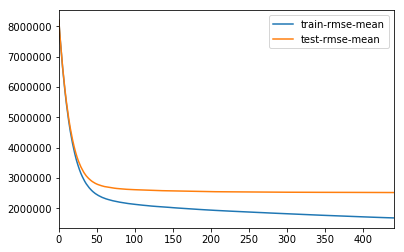

In [4]:
num_boost_rounds = len(cv_result)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()

In [5]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

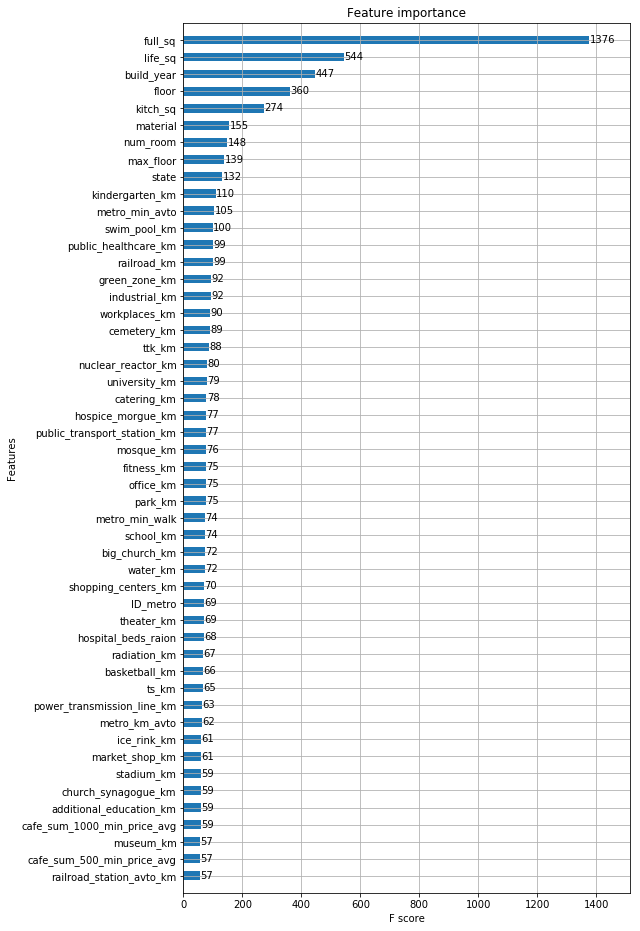

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [7]:
x_pred = model.predict(dtrain)

In [8]:
x_pred

array([  5447486.5,   5519910.5,   5305828.5, ...,   5368549.5,
        11039783. ,   5933061. ], dtype=float32)

In [9]:
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

In [10]:
rmsle(x_pred,y_train)

0.42229682604810875

In [11]:
y_pred = model.predict(dtest)

df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

df_sub.to_csv('subxgb.csv', index=False)